 <center><h2> Pulsar Classification in the HTRU2 Dataset using Support Vector Machines</h1></center>

In [123]:
# Importing all the libraraies

import pandas as pd
from scipy.io import arff
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay 
from sklearn import svm
from imblearn.over_sampling import SMOTE

In [124]:
# Importing the data in arff format
data_arff, meta_arff = arff.loadarff('HTRU_2.arff')
df_arff = pd.DataFrame(data_arff)

In [125]:
df_arff.head() # Viewing the top 5 rows of the dataset

,Profile_mean,Profile_stdev,Profile_skewness,Profile_kurtosis,DM_mean,DM_stdev,DM_skewness,DM_kurtosis,class
0,140.562500,55.683782,-0.234571,-0.699648,3.199833,19.110426,7.975532,74.242225,b'0'
1,102.507812,58.882430,0.465318,-0.515088,1.677258,14.860146,10.576487,127.393580,b'0'
2,103.015625,39.341649,0.323328,1.051164,3.121237,21.744669,7.735822,63.171909,b'0'
3,136.750000,57.178449,-0.068415,-0.636238,3.642977,20.959280,6.896499,53.593661,b'0'
4,88.726562,40.672225,0.600866,1.123492,1.178930,11.468720,14.269573,252.567306,b'0'


In [126]:
df_arff.shape # Printing the rows sand columns of the dataset

(17898, 9)

In [127]:
df_arff.columns # Viewing the columns of the dataset

Index(['Profile_mean', 'Profile_stdev', 'Profile_skewness', 'Profile_kurtosis',
       'DM_mean', 'DM_stdev', 'DM_skewness', 'DM_kurtosis', 'class'],
      dtype='object')

In [128]:
df_arff.info() #Observing the datatypes and null count in the dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17898 entries, 0 to 17897
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Profile_mean      17898 non-null  float64
 1   Profile_stdev     17898 non-null  float64
 2   Profile_skewness  17898 non-null  float64
 3   Profile_kurtosis  17898 non-null  float64
 4   DM_mean           17898 non-null  float64
 5   DM_stdev          17898 non-null  float64
 6   DM_skewness       17898 non-null  float64
 7   DM_kurtosis       17898 non-null  float64
 8   class             17898 non-null  object 
dtypes: float64(8), object(1)
memory usage: 1.2+ MB


In [129]:
df_arff['class'].value_counts() # Looking at the unique values of the class feature

class
b'0'    16259
b'1'     1639
Name: count, dtype: int64

The class variable is an object with binary 0 or 1 categories. We will convert it into an integer.

In [130]:
df_arff['class'] = df_arff['class'].apply(lambda x: x.decode('utf-8')) # Converting the class feature to understand the utf-8 format of the 
# b'0' and b'1' values of the class feature and converting them into integer values

In [131]:
df_arff['class'].value_counts() # Viewing the same feature again

class
0    16259
1     1639
Name: count, dtype: int64

#### Studying the dataset to identify the independant and target features

In [132]:
X = df_arff.iloc[:,:-1].columns.to_list() # Defining the independant features
y = df_arff.iloc[:,-1:].columns.to_list() # Defining the target feature

In [133]:
print('The independant features are: ', X)
print('\nThe target feature is: ', y)

The independant features are:  ['Profile_mean', 'Profile_stdev', 'Profile_skewness', 'Profile_kurtosis', 'DM_mean', 'DM_stdev', 'DM_skewness', 'DM_kurtosis']

The target feature is:  ['class']


The target feature would be class as it has categorical binary values.<br>

The independant features are:
- profile mean
- profile std dev
- profile skewness
- profile kurtosis
- DM SNR mean
- DM SNR std dev
- DM SNR skewness
- DM SNR kurtosis

The target variable is binary form and indicates whether or not a pulsar is present, while the independent variables are the statistical measurements of radio signals referred to as pulsars.

In [134]:
df_arff.describe() # Describing the dataset to view the statistical figures

,Profile_mean,Profile_stdev,Profile_skewness,Profile_kurtosis,DM_mean,DM_stdev,DM_skewness,DM_kurtosis
count,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000
mean,111.079968,46.549532,0.477857,1.770279,12.614400,26.326515,8.303556,104.857709
std,25.652935,6.843189,1.064040,6.167913,29.472897,19.470572,4.506092,106.514540
min,5.812500,24.772042,-1.876011,-1.791886,0.213211,7.370432,-3.139270,-1.976976
25%,100.929688,42.376018,0.027098,-0.188572,1.923077,14.437332,5.781506,34.960504
50%,115.078125,46.947479,0.223240,0.198710,2.801839,18.461316,8.433515,83.064556
75%,127.085938,51.023202,0.473325,0.927783,5.464256,28.428104,10.702959,139.309330
max,192.617188,98.778911,8.069522,68.101622,223.392141,110.642211,34.539844,1191.000837


- The data spans a wide range of values, especially noted in the max values for both profile and DM-related features, suggesting the presence of significant outliers or anomalies.
- The large difference between 75% percentile and max values in variables like Profile_kurtosis and DM_kurtosis further supports the existence of outliers, indicating extremely tailed distributions in some instances.
- There is skewness in the dataset as indicated by the mean values varying from the median.

#### Checking for missing values in the dataset.

In [135]:
df_arff.isnull().sum() #Checking for null values

Profile_mean        0
Profile_stdev       0
Profile_skewness    0
Profile_kurtosis    0
DM_mean             0
DM_stdev            0
DM_skewness         0
DM_kurtosis         0
class               0
dtype: int64

There are no null values.

#### Visualizing outliers for each variable using boxplots.

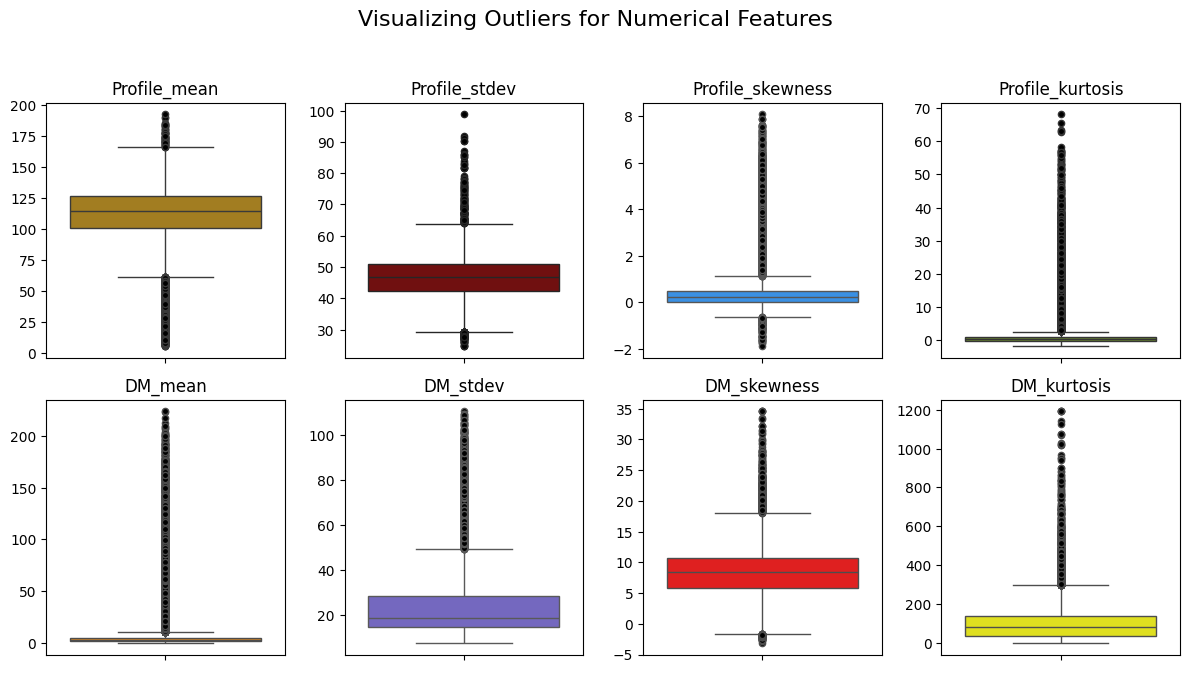

In [136]:
# Plotting the subplots for all the independant features to see if any ooutliers are present or not
column_names = df_arff.columns 

fig, axs = plt.subplots(2, 4, figsize=(12, 7))
colors = ['darkgoldenrod', 'maroon', 'dodgerblue', 'olivedrab', 'darkorange', 'slateblue', 'red', 'yellow']
#Creating a for loop to plot each feature in the dataset
i = 0
for row in range(2):
    for col in range(4):
        if i < len(column_names): 
            sns.boxplot(y=column_names[i], data=df_arff, ax=axs[row][col], color=colors[i % len(colors)], 
                        flierprops=dict(markerfacecolor='black', marker='.', markersize=9))
            axs[row][col].set_title(column_names[i])
            axs[row][col].set(ylabel=None)  
            i += 1

plt.suptitle('Visualizing Outliers for Numerical Features', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  
plt.show()

As a regularization parameter, the C parameter in SVM affects the trade-off between minimizing model complexity for improved generalization and getting a low error rate on the training set. The impact of the C parameter on outlier classification is as follows:
- Hard Margin SVM: The SVM model tries to correctly classify every training example if you set a very high value for C. This classification is referred to as hard margin. High C values force the SVM to locate the decision boundary as close to the data points as possible in order to classify the training data with a very narrow margin. A high C can lead to overfitting in datasets containing outliers as the model tries to fit the outliers in the training set.
- Soft Margin SVM: Soft margin classification is defined as allowing certain misclassifications with a lower value of C. Even though the larger-margin separating hyperplane in this case misclassifies more points, the SVM finds it. A lower C value is advantageous for data containing outliers because it enables the model to ignore some of the outliers, improving generalization abilities.

Lower values typically improve the model's generalization despite the presence of outliers, while higher values make the model sensitive to outliers, risking overfitting. Balancing this parameter, possibly in combination with preprocessing steps to handle outliers, is key to building robust SVM models.

#### Checking the distribution of the target variable and explaining whether it is a balanced or imbalanced dataset.

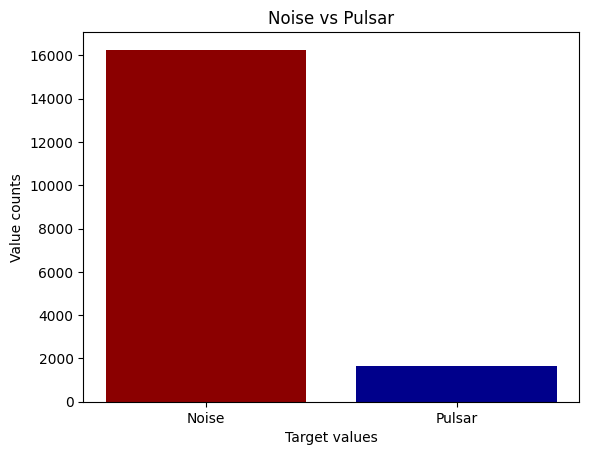

In [137]:
target_variable = df_arff['class'].value_counts()
# Plotting the count of rows in the target variable
plt.bar(target_variable.index, target_variable.values, color=['darkred','darkblue'])
plt.title('Noise vs Pulsar')
plt.xlabel('Target values')
plt.ylabel('Value counts')
plt.xticks([0,1],['Noise','Pulsar'])
plt.show()

The target value is categorical, wherein class 0 indicates as Noise and class 1 indicates Pulsar. As we can observe, the count of Noise values are a lot more than the count of Pulse values. This indicates that there is an imbalanceness in the dataset.

To treat the imbalanceness in the dataset we can do:
- Oversampling: A technique to increase the number of instances in the class with fewer instances by duplicating them, aiming to balance class distribution.
- Undersampling: A method that reduces the number of instances in the class with more instances by randomly removing them, to equalize the class sizes in the dataset.
- SMOTE: Enhances class balance by creating synthetic examples rather than by over-sampling with replacement, using nearest neighbors to interpolate new data points between existing ones.

We will be performing SMOTE analysis on the dataset.

In [138]:
X = df_arff.iloc[:,:-1] # Creating variable with independant features
y = df_arff.iloc[:,-1:] # Creating variable with target feature

In [139]:
smote = SMOTE(random_state=100) #Instantiating SMOTE
X_smote, y_smote = smote.fit_resample(X,y) #Fitting it
data_smote = pd.concat([X_smote,y_smote],axis=1)

In [140]:
print('Count of rows before SMOTE analysis:', df_arff.shape)
print('Count of rows after SMOTE analysis:', data_smote.shape)

Count of rows before SMOTE analysis: (17898, 9)
Count of rows after SMOTE analysis: (32518, 9)


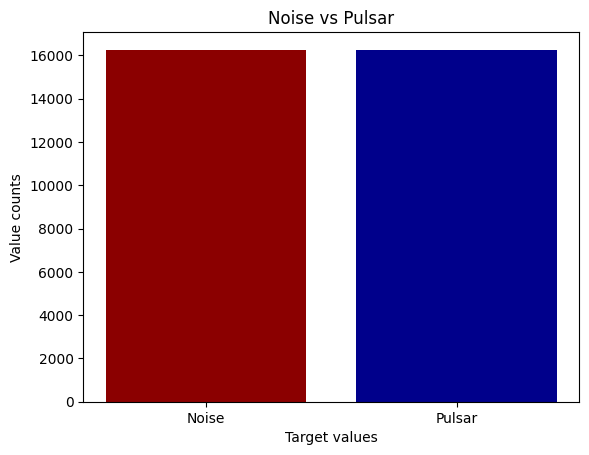

In [141]:
target_variable = data_smote['class'].value_counts()
#Plotting the target feature again to view the change
plt.bar(target_variable.index, target_variable.values, color=['darkred','darkblue'])
plt.title('Noise vs Pulsar')
plt.xlabel('Target values')
plt.ylabel('Value counts')
plt.xticks([0,1],['Noise','Pulsar'])
plt.show()

As we can see, the imbalanceness in the dataset has been treated.

#### Fitting a SVM classifier on the training data with gamma = auto and C/kernel according to the table below. 


| kernel | linear | rbf | sigmoid | poly |
| -- | -- | -- | -- | -- |
| C | 1 | 1 | 1 | 1 | 
| C | 100 | 100 | 100 | 100 | 		
| C | 500 | 500 | 500 | 500 | 

#### Predicting the target variable on the testing dataset.

#### Comparing the performance e.g., Accuracy of classifications.


In [142]:
def model_evaluation(model,y_train, y_test,X_train_sc,X_test_sc): # Model evaluation function that outputs the train and test accuracy. 
                                                                             
    ### Model Accuracy - Train
    y_pred_train = model.predict(X_train_sc)
    accuracy = accuracy_score(y_train, y_pred_train)
    print("Training Accuracy of this model:", accuracy)

    ### Model Accuracy - Test
    y_pred_test = model.predict(X_test_sc)
    accuracy = accuracy_score(y_test, y_pred_test)
    print("Testing Accuracy of this model:", accuracy)

    ### Confusion Matrix 
    conf_matrix = confusion_matrix(y_test, y_pred_test) # Confusion matrix of the predictions and the classification report of the same.
    print("\nConfusion Matrix:")
    cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = [1, 0])
    cm_display.plot()
    plt.show()

    ### Report of the model:
    classification_rep = classification_report(y_test, y_pred_test)
    print("\nClassification Report:")
    print(classification_rep)

In [143]:
# Split the dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.2, random_state= 100)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fitting the models on different kernels
kernels = ['linear', 'rbf', 'sigmoid', 'poly']
C_values = [1,100,500]
model_results = {}

Evaluating the SVM with kernel: linear and C value: 1


c:\Users\balde\anaconda3\envs\logvssvm\Lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training Accuracy of this model: 0.9435304067040824
Testing Accuracy of this model: 0.9449569495694957

Confusion Matrix:


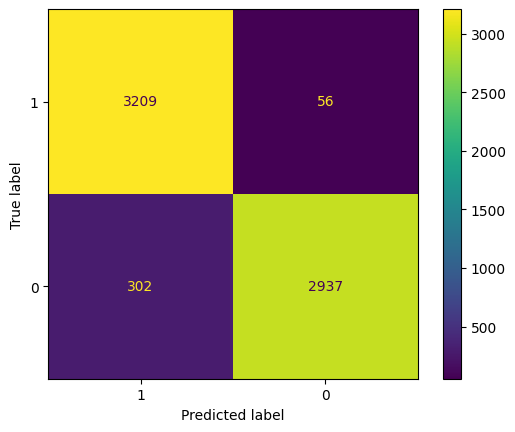


Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.98      0.95      3265
           1       0.98      0.91      0.94      3239

    accuracy                           0.94      6504
   macro avg       0.95      0.94      0.94      6504
weighted avg       0.95      0.94      0.94      6504

************************************************************
Evaluating the SVM with kernel: linear and C value: 100


c:\Users\balde\anaconda3\envs\logvssvm\Lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training Accuracy of this model: 0.9434535250249866
Testing Accuracy of this model: 0.9444956949569495

Confusion Matrix:


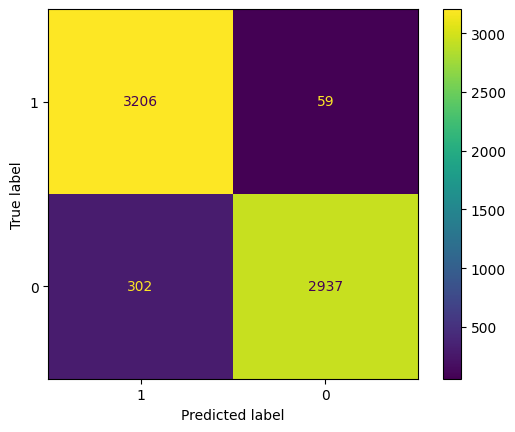


Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.98      0.95      3265
           1       0.98      0.91      0.94      3239

    accuracy                           0.94      6504
   macro avg       0.95      0.94      0.94      6504
weighted avg       0.95      0.94      0.94      6504

************************************************************
Evaluating the SVM with kernel: linear and C value: 500


c:\Users\balde\anaconda3\envs\logvssvm\Lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training Accuracy of this model: 0.9434919658645344
Testing Accuracy of this model: 0.9444956949569495

Confusion Matrix:


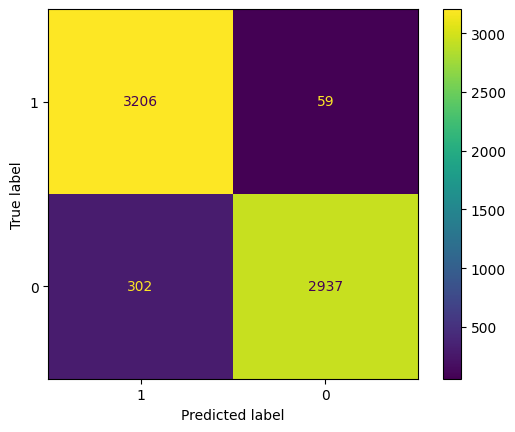


Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.98      0.95      3265
           1       0.98      0.91      0.94      3239

    accuracy                           0.94      6504
   macro avg       0.95      0.94      0.94      6504
weighted avg       0.95      0.94      0.94      6504

************************************************************
Evaluating the SVM with kernel: rbf and C value: 1


c:\Users\balde\anaconda3\envs\logvssvm\Lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training Accuracy of this model: 0.9482586299684785
Testing Accuracy of this model: 0.9477244772447725

Confusion Matrix:


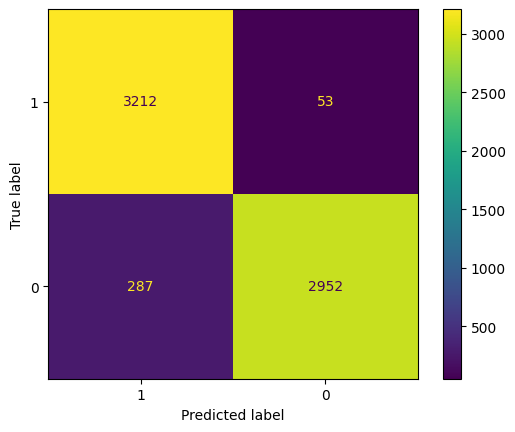


Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      3265
           1       0.98      0.91      0.95      3239

    accuracy                           0.95      6504
   macro avg       0.95      0.95      0.95      6504
weighted avg       0.95      0.95      0.95      6504

************************************************************
Evaluating the SVM with kernel: rbf and C value: 100


c:\Users\balde\anaconda3\envs\logvssvm\Lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training Accuracy of this model: 0.95214115476282
Testing Accuracy of this model: 0.9515682656826568

Confusion Matrix:


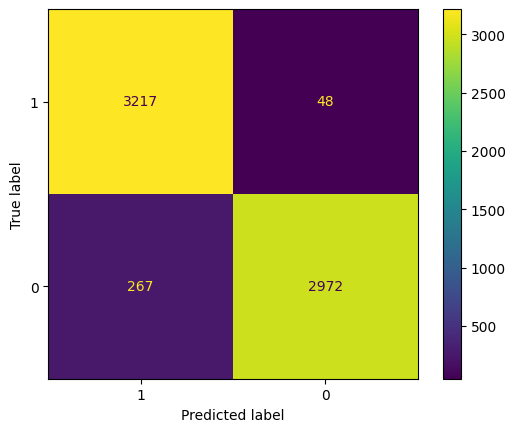


Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.99      0.95      3265
           1       0.98      0.92      0.95      3239

    accuracy                           0.95      6504
   macro avg       0.95      0.95      0.95      6504
weighted avg       0.95      0.95      0.95      6504

************************************************************
Evaluating the SVM with kernel: rbf and C value: 500


c:\Users\balde\anaconda3\envs\logvssvm\Lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training Accuracy of this model: 0.9546782501729838
Testing Accuracy of this model: 0.9515682656826568

Confusion Matrix:


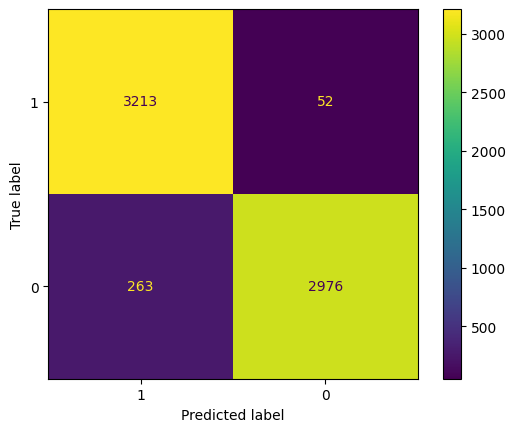


Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      3265
           1       0.98      0.92      0.95      3239

    accuracy                           0.95      6504
   macro avg       0.95      0.95      0.95      6504
weighted avg       0.95      0.95      0.95      6504

************************************************************
Evaluating the SVM with kernel: sigmoid and C value: 1


c:\Users\balde\anaconda3\envs\logvssvm\Lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training Accuracy of this model: 0.8723764127008534
Testing Accuracy of this model: 0.8710024600246002

Confusion Matrix:


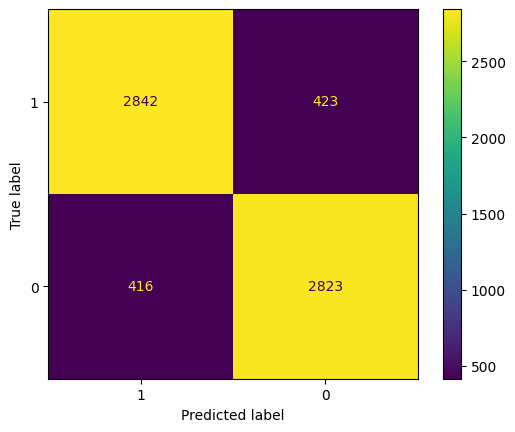


Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.87      0.87      3265
           1       0.87      0.87      0.87      3239

    accuracy                           0.87      6504
   macro avg       0.87      0.87      0.87      6504
weighted avg       0.87      0.87      0.87      6504

************************************************************
Evaluating the SVM with kernel: sigmoid and C value: 100


c:\Users\balde\anaconda3\envs\logvssvm\Lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training Accuracy of this model: 0.8720688859844699
Testing Accuracy of this model: 0.8708487084870848

Confusion Matrix:


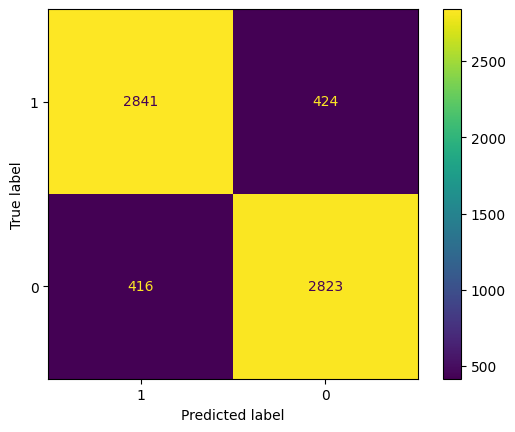


Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.87      0.87      3265
           1       0.87      0.87      0.87      3239

    accuracy                           0.87      6504
   macro avg       0.87      0.87      0.87      6504
weighted avg       0.87      0.87      0.87      6504

************************************************************
Evaluating the SVM with kernel: sigmoid and C value: 500


c:\Users\balde\anaconda3\envs\logvssvm\Lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training Accuracy of this model: 0.8720688859844699
Testing Accuracy of this model: 0.8708487084870848

Confusion Matrix:


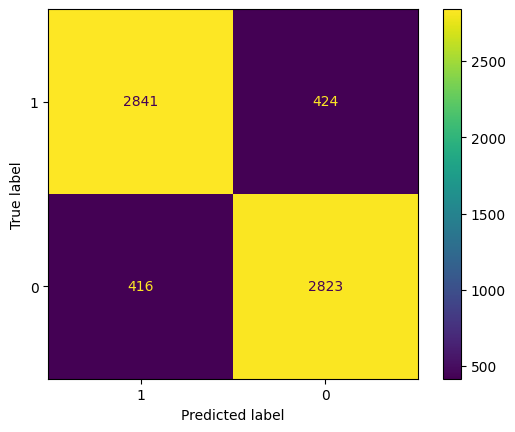


Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.87      0.87      3265
           1       0.87      0.87      0.87      3239

    accuracy                           0.87      6504
   macro avg       0.87      0.87      0.87      6504
weighted avg       0.87      0.87      0.87      6504

************************************************************
Evaluating the SVM with kernel: poly and C value: 1


c:\Users\balde\anaconda3\envs\logvssvm\Lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training Accuracy of this model: 0.9424540631967402
Testing Accuracy of this model: 0.9423431734317343

Confusion Matrix:


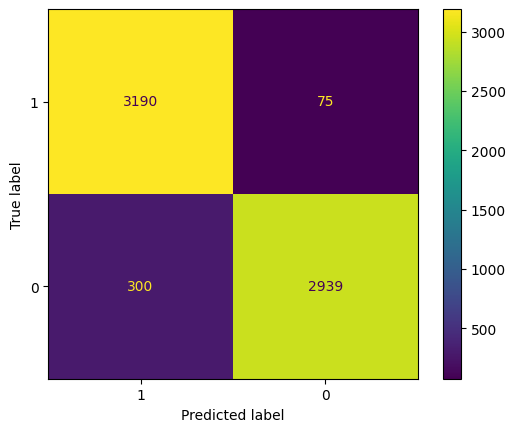


Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.98      0.94      3265
           1       0.98      0.91      0.94      3239

    accuracy                           0.94      6504
   macro avg       0.94      0.94      0.94      6504
weighted avg       0.94      0.94      0.94      6504

************************************************************
Evaluating the SVM with kernel: poly and C value: 100


c:\Users\balde\anaconda3\envs\logvssvm\Lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training Accuracy of this model: 0.9498347043899439
Testing Accuracy of this model: 0.9491082410824109

Confusion Matrix:


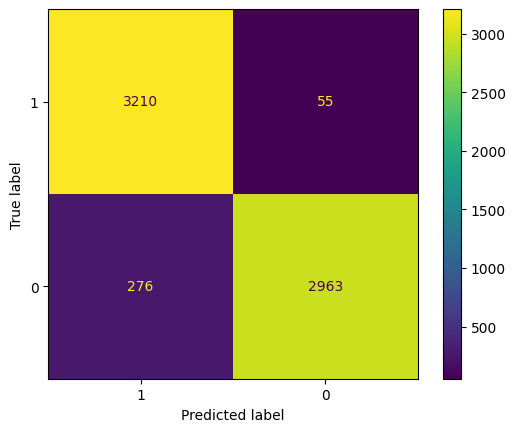


Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      3265
           1       0.98      0.91      0.95      3239

    accuracy                           0.95      6504
   macro avg       0.95      0.95      0.95      6504
weighted avg       0.95      0.95      0.95      6504

************************************************************
Evaluating the SVM with kernel: poly and C value: 500


c:\Users\balde\anaconda3\envs\logvssvm\Lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training Accuracy of this model: 0.9502959944645191
Testing Accuracy of this model: 0.9498769987699877

Confusion Matrix:


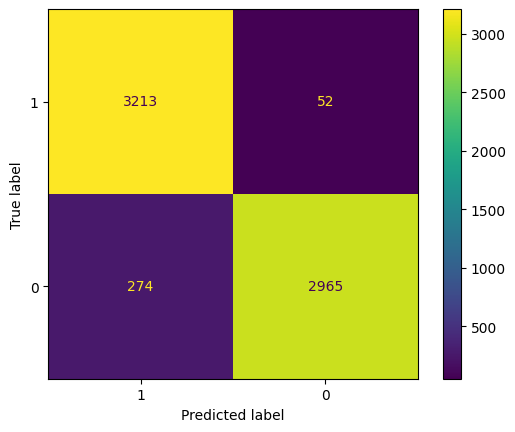


Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      3265
           1       0.98      0.92      0.95      3239

    accuracy                           0.95      6504
   macro avg       0.95      0.95      0.95      6504
weighted avg       0.95      0.95      0.95      6504

************************************************************


In [144]:
# Looping the kernel and C values and fitting the model on the values and evaluating their performances
for k in kernels:
    for c in C_values:
        print(f"Evaluating the SVM with kernel: {k} and C value: {c}")
        model = svm.SVC(kernel=k, C=c,gamma='auto')
        model.fit(X_train_scaled, y_train)
        model_evaluation(model, y_train, y_test, X_train_scaled, X_test_scaled)
        print('**' * 30)
        

#### Inferences

The performances with fixed kernels and changes in C are:
- Linear kernel:
    - C = 1 <br>
        Training Accuracy of this model: 0.9434535250249866<br>
        Testing Accuracy of this model: 0.9444956949569495
    - C = 100 <br>
        Training Accuracy of this model: 0.9434535250249866 <br> 
        Testing Accuracy of this model: 0.9444956949569495
    - C = 500 <br> 
        Training Accuracy of this model: 0.9434919658645344 <br>
        Testing Accuracy of this model: 0.9444956949569495

With the increase in C values for the linear kernel, there are no significant improvements in the training or testing accuracy as well as the recall, precision and f1-scores are the same for all the C values. This shows that the liner kernel is not sensitive with the changes being made to C. This could indicate that the data is linearly seperable since there no changes in any of the performance metrics with the changes in the values of C.

- Rbf kernel:
    - C = 1 <br>
        Training Accuracy of this model: 0.9482586299684785<br>
        Testing Accuracy of this model: 0.9477244772447725
    - C = 100 <br>
        Training Accuracy of this model: 0.95214115476282 <br> 
        Testing Accuracy of this model: 0.9515682656826568
    - C = 500 <br> 
        Training Accuracy of this model: 0.9546782501729838 <br>
        Testing Accuracy of this model: 0.9515682656826568

With the increase in C values for the rbf kernel, there are slight improvements in the training and testing accuracy as well as the recall, precision and f1-scores are also improving for the C values. This shows that the rbf kernel is  sensitive with the changes being made to C. 

- Sigmoid kernel:
    - C = 1 <br>
        Training Accuracy of this model: 0.8723764127008534<br>
        Testing Accuracy of this model: 0.8710024600246002
    - C = 100 <br>
        Training Accuracy of this model: 0.8720688859844699 <br> 
        Testing Accuracy of this model: 0.8708487084870848
    - C = 500 <br> 
        Training Accuracy of this model: 0.8720688859844699 <br>
        Testing Accuracy of this model: 0.8708487084870848

With the increase in C values for the sigmoid kernel, there are slight reductions in the training and testing accuracy as well as the recall, precision and f1-scores are also the same for the C values and the values are also low compared to other kernels. This indicates that there is no improvement in this kernel with any changes to the C values, suggesting that it might not be the best choice for this particular dataset.

- Polynomial kernel:
    - C = 1 <br>
        Training Accuracy of this model: 0.9424540631967402<br>
        Testing Accuracy of this model: 0.9423431734317343
    - C = 100 <br>
        Training Accuracy of this model: 0.9498347043899439 <br> 
        Testing Accuracy of this model: 0.9491082410824109
    - C = 500 <br> 
        Training Accuracy of this model: 0.9502959944645191 <br>
        Testing Accuracy of this model: 0.9498769987699877

With the increase in C values for the polynomial kernel, there are improvements in the training and testing accuracy as well as the recall, precision and f1-scores are also increasing for the C values. The ppolynomial kernel improves a lot with a harder margin which indicates that the polynomial kernels captures complex patterns a lot better at higher levels of C.

#### Any case of overfitting

Overfitting occurs when a model learns the detail and noise in the training data to the extent that it negatively impacts the performance of the model on new data. This means the model is too complex, capturing patterns that do not generalize to unseen data.

- Linear kernel: In the model with the linear kernel, the training and testingg accuracies are almost identical which indicates that there is no overfitting.
- rbf kernel: In the model with the rbf kernel, the training and testing accuracies increase with the increase in the c values and are very close to each other which indicates that the model is not overfitting in generalizing the data very well.
- sigmoid kernel: In the case of the sigmoid kernel, the trianing and testing accuracies are again very similar but with the increase in the c values, the testing accuracies are slightly decreasing a bit more than the training accuracies which increases the gap between the two. This is the only kernel that could indicate a slight overfitting.
- poloynoial kernel: Finally, in the case of polynomial kernel, the training and testing accuracies are again very close to each other. With the increase in C values, the training and testing accuracies are both incerasing. However, with the last C values(500), the testing accuracy slightly decreases whereas the training accuracy increases. This could indicate a very slight overfitting but it is unlikely that is the case.

#### Conclusion

Based on the analysis and results of the SVM classifier on the pulsar dataset after applying SMOTE for handling class imbalance, we can draw several conclusions:

1. Class Imbalance Handling: The application of SMOTE significantly improved the balance between classes in the dataset, increasing the total number of instances and making the training process more effective by providing more examples of the minority class.

2. Model Performance Across Different Kernels:
    - Linear Kernel: Showed stable performance with no signs of overfitting, as indicated by consistent training and testing accuracies.
    - RBF Kernel: Displayed robust generalization capabilities, with accuracies improving as the penalty parameter C increased, suggesting a well-fitted model across different complexity settings.
    - Sigmoid Kernel: This was the only kernel showing potential overfitting with increasing C values, as the gap between training and testing accuracies widened.
    - Polynomial Kernel: Performed exceptionally well, especially at higher C values, capturing complex patterns effectively. However, a slight indication of overfitting was noted at the highest C value used.
3. Kernel Choice and Parameter Tuning: The choice of kernel and the tuning of the C parameter significantly influenced the model's performance. Polynomial and RBF kernels, with higher C values, generally provided better performance metrics, suggesting that these kernels are more suited for capturing the intricacies in the pulsar data.

4. Implications and Future Work: The promising results of SVM with SMOTE indicate a potential for further exploratory work using even more complex models or more refined hyperparameter tuning. Additionally, other methods for handling class imbalances, such as different synthetic data generation techniques, could be explored to further enhance model reliability and accuracy.

This analysis not only highlights the effectiveness of SVM in classifying pulsars from noise but also underscores the importance of proper preprocessing and model tuning in achieving high-performance predictive models. Future studies could focus on comparative analysis with other machine learning algorithms to benchmark SVM's performance in this specific context.